
    This Source Code Form is subject to the terms of the Mozilla Public
    License, v. 2.0. If a copy of the MPL was not distributed with this
    file, You can obtain one at http://mozilla.org/MPL/2.0/.


In [1]:
# Logger
import logging
logging.basicConfig(level=logging.WARN)

# Enable automatic module reload
%load_ext autoreload
%autoreload 2

# Load PyALCS ACSM module
from bacs.agents.bacs import BACS, Configuration
from bacs.agents.bacs.utils.GymMazeWrapper import _maze_metrics, parse_metrics_to_df, plot_performance

# Load environments
import gym
import my_mazes

# Agent - BACS

## Common parameters

In [2]:
CLASSIFIER_LENGTH = 8
NUMBER_OF_POSSIBLE_ACTIONS = 8

MAZE = "Woods101-v0"

NUMBER_OF_EXPLORE_TRIALS = 1000
METRICS_TRIAL_FREQUENCY_EXPLORE = 10
BETA_EXPLORE = 0.05
EPSILON = 0.8

NUMBER_OF_EXPLOIT_TRIALS_NO_RL = 500
BETA_EXPLOIT_NO_RL = 0.00

NUMBER_OF_EXPLOIT_TRIALS_RL_START = 100
BETA_EXPLOIT_RL_START = 0.05

NUMBER_OF_EXPLOIT_TRIALS_RL = 500
BETA_EXPLOIT_RL = 0.05

LENGTH_OF_BEHAVIORAL_SEQUENCES = 1

ENABLE_PEE = True

## Environment - Maze

In [3]:
# Initialize environment
maze = gym.make(MAZE)
# Reset it, by putting an agent into random position
situation = maze.reset()
# Render the state in ASCII
maze.render()


■ ■ ■ ■ ■ ■ ■
■ □ □ □ □ □ ■
■ A ■ □ ■ □ ■
■ □ ■ $ ■ □ ■
■ ■ ■ ■ ■ ■ ■


## Training of BACS - Exploration

In [4]:
%%time

cfg_explore = Configuration(
    classifier_length=CLASSIFIER_LENGTH,
    number_of_possible_actions=NUMBER_OF_POSSIBLE_ACTIONS,
    user_metrics_collector_fcn=_maze_metrics,
    metrics_trial_frequency=METRICS_TRIAL_FREQUENCY_EXPLORE,
    do_pee=ENABLE_PEE,
    do_ga=False,
    do_subsumption=True,
    beta=BETA_EXPLORE,
    gamma=0.95,
    theta_i=0.1,
    theta_r=0.9,
    epsilon=EPSILON,
    u_max=CLASSIFIER_LENGTH,
    theta_exp=20,
    theta_ga=100,
    theta_as=20,
    mu=0.3,
    chi=0.8,
    bs_max=LENGTH_OF_BEHAVIORAL_SEQUENCES
)

agent_explore = BACS(cfg_explore)
population_explore, metrics_explore = agent_explore.explore(maze, NUMBER_OF_EXPLORE_TRIALS)

CPU times: user 19.2 s, sys: 33.5 ms, total: 19.2 s
Wall time: 19.2 s


In [5]:
population_explore.sort(key=lambda cl: -cl.fitness)
population_explore_to_display = [cl for cl in population_explore]
for cl in population_explore_to_display:
    print(cl)
    print("\n")

#0##9##0 4 None #1##1##1         (empty)               q: 1.0   r: 1e+03  ir: 1e+03  f: 1e+03  exp: 991 tga: 64    talp: 22238 tav: 18.1   num: 1 ee: False


110#0#01 4 None 001#9#10         (empty)               q: 1.0   r: 950.0  ir: 0.0    f: 950.0  exp: 387 tga: 7     talp: 22074 tav: 63.2   num: 1 ee: False


110#0101 4 None {0:100%}{0:100%}{1:100%}#9#10 (empty)               q: 1.0   r: 950.0  ir: 0.0    f: 950.0  exp: 380 tga: 208   talp: 22074 tav: 63.2   num: 1 ee: False


0011011# 1 [3] ####9##0         (empty)               q: 1.0   r: 949.0  ir: 0.0    f: 949.0  exp: 429 tga: 489   talp: 22231 tav: 46.2   num: 1 ee: False


1#1101## 6 [5] 00##9#10         (empty)               q: 1.0   r: 949.0  ir: 0.0    f: 949.0  exp: 420 tga: 511   talp: 22236 tav: 51.9   num: 1 ee: False


0#110110 7 [5] #0##9###         (empty)               q: 1.0   r: 949.0  ir: 0.0    f: 949.0  exp: 422 tga: 694   talp: 22222 tav: 41.7   num: 1 ee: False


##01011# 2 [3] 001#9##0         (empty)   

## Exploitation of BACS

### Exploitation without Reinforcement Module

In [6]:
%%time

cfg_exploit_no_rl = Configuration(
    classifier_length=CLASSIFIER_LENGTH,
    number_of_possible_actions=NUMBER_OF_POSSIBLE_ACTIONS,
    user_metrics_collector_fcn=None,
    metrics_trial_frequency=1,
    do_pee=ENABLE_PEE,
    do_ga=False,
    do_subsumption=True,
    beta=BETA_EXPLOIT_NO_RL,
    gamma=0.95,
    theta_i=0.1,
    theta_r=0.9,
    epsilon=0.0,
    u_max=CLASSIFIER_LENGTH,
    theta_exp=20,
    theta_ga=100,
    theta_as=20,
    mu=0.3,
    chi=0.8,
    bs_max=LENGTH_OF_BEHAVIORAL_SEQUENCES
)

agent_exploit_no_rl = BACS(cfg_exploit_no_rl, population_explore)
agent_exploit_no_rl.clean_population(does_anticipate_change=True, is_reliable=False)
population_exploit_no_rl, metrics_exploit_no_rl = agent_exploit_no_rl.exploit(maze, NUMBER_OF_EXPLOIT_TRIALS_NO_RL)


CPU times: user 295 ms, sys: 1.91 ms, total: 297 ms
Wall time: 298 ms


In [7]:
%%time

cfg_exploit_rl_start = Configuration(
    classifier_length=CLASSIFIER_LENGTH,
    number_of_possible_actions=NUMBER_OF_POSSIBLE_ACTIONS,
    user_metrics_collector_fcn=None,
    metrics_trial_frequency=1,
    do_pee=ENABLE_PEE,
    do_ga=False,
    do_subsumption=True,
    beta=BETA_EXPLOIT_RL_START,
    gamma=0.95,
    theta_i=0.1,
    theta_r=0.9,
    epsilon=0.0,
    u_max=CLASSIFIER_LENGTH,
    theta_exp=20,
    theta_ga=100,
    theta_as=20,
    mu=0.3,
    chi=0.8,
    bs_max=LENGTH_OF_BEHAVIORAL_SEQUENCES
)

agent_exploit_rl_start = BACS(cfg_exploit_rl_start, population_exploit_no_rl)
agent_exploit_rl_start.clean_population(does_anticipate_change=True, is_reliable=False)
population_exploit_rl_start, metrics_exploit_rl_start = agent_exploit_rl_start.exploit(maze, NUMBER_OF_EXPLOIT_TRIALS_RL_START)


CPU times: user 74 ms, sys: 1.02 ms, total: 75 ms
Wall time: 74.3 ms


In [8]:
%%time

cfg_exploit_rl = Configuration(
    classifier_length=CLASSIFIER_LENGTH,
    number_of_possible_actions=NUMBER_OF_POSSIBLE_ACTIONS,
    user_metrics_collector_fcn=None,
    metrics_trial_frequency=1,
    do_pee=ENABLE_PEE,
    do_ga=False,
    do_subsumption=True,
    beta=BETA_EXPLOIT_RL,
    gamma=0.95,
    theta_i=0.1,
    theta_r=0.9,
    epsilon=0.0,
    u_max=CLASSIFIER_LENGTH,
    theta_exp=20,
    theta_ga=100,
    theta_as=20,
    mu=0.3,
    chi=0.8,
    bs_max=LENGTH_OF_BEHAVIORAL_SEQUENCES
)

agent_exploit_rl = BACS(cfg_exploit_rl, population_exploit_rl_start)
agent_exploit_rl.clean_population(does_anticipate_change=True, is_reliable=False)
population_exploit_rl, metrics_exploit_rl = agent_exploit_rl.exploit(maze, NUMBER_OF_EXPLOIT_TRIALS_RL)

CPU times: user 262 ms, sys: 1.42 ms, total: 263 ms
Wall time: 263 ms


### Performance

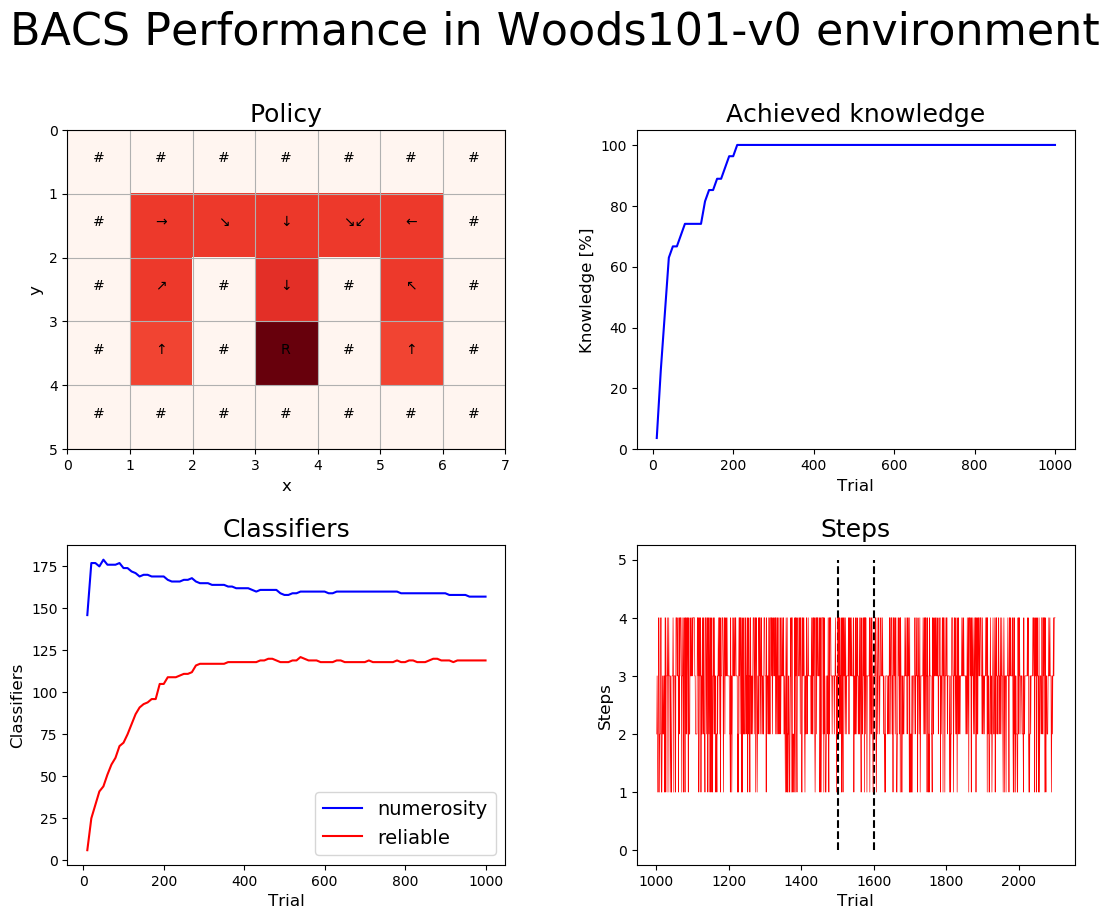

In [9]:
metrics_trial_frequency_explore = cfg_explore.metrics_trial_frequency
metrics_trial_frequency_exploit = 1

metrics_exploit = metrics_exploit_no_rl.copy()
for idx, item in enumerate(metrics_exploit_rl_start):
    tmp = item.copy()
    tmp['trial'] += NUMBER_OF_EXPLOIT_TRIALS_NO_RL
    metrics_exploit.append(tmp)
for idx, item in enumerate(metrics_exploit_rl):
    tmp = item.copy()
    tmp['trial'] += NUMBER_OF_EXPLOIT_TRIALS_NO_RL + NUMBER_OF_EXPLOIT_TRIALS_RL_START
    metrics_exploit.append(tmp)

metrics_df = parse_metrics_to_df(metrics_explore, metrics_trial_frequency_explore, metrics_exploit, metrics_trial_frequency_exploit)
plot_performance(agent_exploit_rl, maze, metrics_df, cfg_exploit_rl, MAZE, metrics_trial_frequency_explore, [NUMBER_OF_EXPLOIT_TRIALS_NO_RL,NUMBER_OF_EXPLOIT_TRIALS_RL_START,NUMBER_OF_EXPLOIT_TRIALS_RL])


In [10]:
avg_step_explore = 0
for trial in metrics_explore:
    avg_step_explore += trial['steps_in_trial']
avg_step_explore /= NUMBER_OF_EXPLORE_TRIALS / metrics_trial_frequency_explore
print("Average number of steps to solve the maze is ",avg_step_explore,
      " for a total of ", NUMBER_OF_EXPLORE_TRIALS, " trials in EXPLORATION")

avg_step_exploit_no_rl = 0
for trial in metrics_exploit_no_rl:
    avg_step_exploit_no_rl += trial['steps_in_trial']
avg_step_exploit_no_rl /= NUMBER_OF_EXPLOIT_TRIALS_NO_RL
print("Average number of steps to solve the maze is ",avg_step_exploit_no_rl,
      " for a total of ", NUMBER_OF_EXPLOIT_TRIALS_NO_RL, " trials in EXPLOITATION without Reinforcement Module")

avg_step_exploit_rl_start = 0
for trial in metrics_exploit_rl_start:
    avg_step_exploit_rl_start += trial['steps_in_trial']
avg_step_exploit_rl_start /= NUMBER_OF_EXPLOIT_TRIALS_RL_START
print("Average number of steps to solve the maze is ",avg_step_exploit_rl_start,
      " for a total of ", NUMBER_OF_EXPLOIT_TRIALS_RL_START, " trials in EXPLOITATION starting Reinforcement Module")

avg_step_exploit_rl = 0
for trial in metrics_exploit_rl:
    avg_step_exploit_rl += trial['steps_in_trial']
avg_step_exploit_rl /= NUMBER_OF_EXPLOIT_TRIALS_RL
print("Average number of steps to solve the maze is ",avg_step_exploit_rl,
      " for a total of ", NUMBER_OF_EXPLOIT_TRIALS_RL, " trials in EXPLOITATION with Reinforcement Module")

print(_maze_metrics(population_exploit_no_rl, maze))
print(_maze_metrics(population_exploit_rl_start, maze))
print(_maze_metrics(population_exploit_rl, maze))

Average number of steps to solve the maze is  21.93  for a total of  1000  trials in EXPLORATION
Average number of steps to solve the maze is  2.868  for a total of  500  trials in EXPLOITATION without Reinforcement Module
Average number of steps to solve the maze is  2.92  for a total of  100  trials in EXPLOITATION starting Reinforcement Module
Average number of steps to solve the maze is  2.856  for a total of  500  trials in EXPLOITATION with Reinforcement Module
{'knowledge': 100.0, 'population': 54, 'numerosity': 54, 'reliable': 47}
{'knowledge': 100.0, 'population': 54, 'numerosity': 54, 'reliable': 47}
{'knowledge': 100.0, 'population': 54, 'numerosity': 54, 'reliable': 47}


In [11]:
population_exploit_rl.sort(key=lambda cl: -cl.fitness)
population_exploit_to_display = [cl for cl in population_exploit_rl]
for cl in population_exploit_to_display:
    print(cl)
    print("\n")

#0##9##0 4 None #1##1##1         (empty)               q: 1.0   r: 1e+03  ir: 1e+03  f: 1e+03  exp: 991 tga: 64    talp: 22238 tav: 18.1   num: 1 ee: False


110#0#01 4 None 001#9#10         (empty)               q: 1.0   r: 950.0  ir: 0.0    f: 950.0  exp: 387 tga: 7     talp: 22074 tav: 63.2   num: 1 ee: False


0#110110 7 [5] #0##9###         (empty)               q: 1.0   r: 949.0  ir: 0.0    f: 949.0  exp: 422 tga: 694   talp: 22222 tav: 41.7   num: 1 ee: False


0011011# 1 [3] ####9##0         (empty)               q: 1.0   r: 949.0  ir: 0.0    f: 949.0  exp: 429 tga: 489   talp: 22231 tav: 46.2   num: 1 ee: False


1#1101## 6 [5] 00##9#10         (empty)               q: 1.0   r: 949.0  ir: 0.0    f: 949.0  exp: 420 tga: 511   talp: 22236 tav: 51.9   num: 1 ee: False


##01011# 2 [3] 001#9##0         (empty)               q: 1.0   r: 949.0  ir: 0.0    f: 949.0  exp: 306 tga: 1150  talp: 22226 tav: 64.7   num: 1 ee: False


11010101 2 [5] 001#9#10         (empty)               q: